# 1D Geometry File Parsing

This notebook demonstrates parsing and manipulating 1D geometry elements from HEC-RAS plain text geometry files, including:
- Cross Section operations
- Hydraulic Property Tables (HTAB)
- Lateral Structure operations
- Batch processing and statistics

## Overview

This notebook demonstrates extraction of **1D geometry elements** from HEC-RAS plain text geometry files (`.g##` format).

### What You'll Learn
- Parse cross sections and extract station-elevation data
- Read hydraulic property tables (HTAB)
- Extract lateral structure information
- Perform batch processing

### LLM Forward Approach
- **Verification**: Check extracted DataFrames against HEC-RAS GUI
- **Visual Outputs**: Plot cross sections for review
- **Audit Trail**: Save extracted data to CSV

### Reference Documentation
- [HEC-RAS User's Manual, Chapter 6](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS Hydraulic Reference Manual](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
from pathlib import Path
import sys

USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import RAS Commander geometry modules
from ras_commander import (
    RasGeometry, GeomLateral,
    RasGeometryUtils,
    HdfHydraulicTables,
    RasExamples,
    init_ras_project,
    RasCmdr,
    ras
)

# Additional imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")
print(f"Working directory: {Path.cwd()}")

📦 PIP PACKAGE MODE: Loading installed ras-commander


✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py
Working directory: C:\GH\ras-commander\examples


## Parameters

Configure these values to customize the notebook for your project.

In [ ]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# Output Configuration
OUTPUTS_DIR = Path("_outputs") / "201_1d_plaintext_geometry"  # Artifacts saved here

# Geometry Settings
GEOM_NUMBER = "01"                # Geometry file number
RIVER = "White"                   # River name for cross section queries
REACH = "West Fork"               # Reach name
CROSS_SECTION = "10457.31"        # Cross section station (RS)

# Create output directory
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Outputs will be saved to: {OUTPUTS_DIR.absolute()}")


## Package Setup and Imports

In [2]:
# NOTE: This cell runs HEC-RAS and may take 1-2 minutes!
# Uncomment to generate preprocessed HDF

# Extract and initialize project
project_path = RasExamples.extract_project(PROJECT_NAME, suffix="201")
init_ras_project(project_path, RAS_VERSION)

# Compute plan to generate preprocessed geometry HDF
print("Computing plan 01 to generate preprocessed geometry HDF...")
print("(This may take 1-2 minutes)\n")
result = RasCmdr.compute_plan("01")

if result:
    geom_hdf = ras.geom_df.iloc[0]['full_path'] + '.hdf'
    print(f"\n✓ Preprocessed HDF created: {Path(geom_hdf).name}")
    print(f"  Location: {geom_hdf}")
else:
    print("ERROR: Plan computation failed")



2025-12-16 21:48:05 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip


2025-12-16 21:48:05 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-12-16 21:48:05 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-12-16 21:48:05 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-16 21:48:05 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek' as 'Balde Eagle Creek_20'


2025-12-16 21:48:05 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20


2025-12-16 21:48:05 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.rasmap


2025-12-16 21:48:05 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20


2025-12-16 21:48:05 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-16 21:48:05 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.prj" "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.p01"


Computing plan 01 to generate preprocessed geometry HDF...
(This may take 1-2 minutes)



2025-12-16 21:49:41 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01


2025-12-16 21:49:41 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 95.65 seconds



✓ Preprocessed HDF created: BaldEagle.g01.hdf
  Location: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.g01.hdf


## Section 1: Cross Section Operations

Cross sections define the channel geometry in 1D models. We'll explore how to list cross sections, extract their station/elevation data, and modify them.

### Verification: Cross Section Data Quality

After extracting cross sections, verify:

1. **Count Matches**: Number matches HEC-RAS GUI
2. **Station Range**: Values in expected range
3. **Data Completeness**: No missing values
4. **Units**: Stations and elevations in correct units

### Common Issues

**Issue**: FileNotFoundError
- **Fix**: Verify geometry file path

**Issue**: Empty DataFrame
- **Fix**: Check river/reach names (case-sensitive)

**Issue**: Station-elevation gaps
- **Fix**: Verify geometry in HEC-RAS GUI

In [3]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,UNET D2 Cores,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,0.0,None,dss,2,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,...,NaN,None,dss,1,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [4]:
ras.geom_df

,geom_file,geom_number,full_path,hdf_path
0,g01,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


### 1.1 Setup: Define Geometry File Path

In [5]:
# Lookup geometry file path and HDF path from ras.geom_df by geom_number
geom_number = "01"
geom_row = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number].iloc[0]

geom_file = Path(geom_row["full_path"])
geom_hdf = Path(geom_row["hdf_path"])

print(f"Geometry file: {geom_file}")
print(f"File exists: {geom_file.exists()}")
if geom_file.exists():
    print(f"File size: {geom_file.stat().st_size / 1024:.1f} KB")
else:
    print("Geometry file does not exist!")
print(f"HDF file: {geom_hdf}")
print(f"HDF exists: {geom_hdf.exists()}")

Geometry file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.g01
File exists: True
File size: 513.6 KB
HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.g01.hdf
HDF exists: True


### 1.2 List All Cross Sections

In [6]:
# Extract all cross sections
xs_df = RasGeometry.get_cross_sections(geom_file)

print(f"Total cross sections: {len(xs_df)}")
print(f"Rivers: {xs_df['River'].unique().tolist()}")
print(f"Reaches: {xs_df['Reach'].unique().tolist()}")

print("\nFirst 10 cross sections:")
display.display(xs_df)

2025-12-16 21:49:41 - ras_commander.geom.GeomCrossSection - INFO - Extracted 189 cross sections from BaldEagle.g01


Total cross sections: 189
Rivers: ['Bald Eagle']
Reaches: ['Loc Hav']

First 10 cross sections:


,River,Reach,RS,Type,Length_Left,Length_Channel,Length_Right,NodeName
0,Bald Eagle,Loc Hav,138154.4,1,358.43,463.64,517.64,
1,Bald Eagle,Loc Hav,137690.8,1,305.71,363.84,382.83,
2,Bald Eagle,Loc Hav,137327.0,1,732.93,762.02,765.36,
3,Bald Eagle,Loc Hav,136564.9,1,349.61,362.64,370.75,
4,Bald Eagle,Loc Hav,136202.3,1,590.50,610.86,647.38,
...,...,...,...,...,...,...,...,...
184,Bald Eagle,Loc Hav,2436,3,0.00,0.00,0.00,
185,Bald Eagle,Loc Hav,2371.827,1,876.88,679.19,422.71,
186,Bald Eagle,Loc Hav,1692.633,1,576.94,479.78,449.20,
187,Bald Eagle,Loc Hav,1212.855,1,526.27,552.91,604.83,


### 1.3 Extract Station/Elevation for a Cross Section

In [7]:
# Select first cross section
first_xs = xs_df.iloc[0]
river = first_xs['River']
reach = first_xs['Reach']
rs = first_xs['RS']

print(f"Selected cross section: {river} / {reach} / RS {rs}")

# Extract station/elevation data
sta_elev = RasGeometry.get_station_elevation(geom_file, river, reach, rs)

print(f"\nStation/Elevation Data:")
print(f"  Points: {len(sta_elev)}")
print(f"  Station range: {sta_elev['Station'].min():.2f} to {sta_elev['Station'].max():.2f} ft")
print(f"  Elevation range: {sta_elev['Elevation'].min():.2f} to {sta_elev['Elevation'].max():.2f} ft")
print(f"  Channel width: {sta_elev['Station'].max() - sta_elev['Station'].min():.2f} ft")

print("\nFirst 10 points:")
display.display(sta_elev.head(10))

2025-12-16 21:49:41 - ras_commander.geom.GeomCrossSection - INFO - Extracted 40 station/elevation pairs for Bald Eagle/Loc Hav/RS 138154.4


Selected cross section: Bald Eagle / Loc Hav / RS 138154.4

Station/Elevation Data:
  Points: 40
  Station range: 0.00 to 557.01 ft
  Elevation range: 656.30 to 706.27 ft
  Channel width: 557.01 ft

First 10 points:


,Station,Elevation
0,0.0,660.41
1,5.0,660.61
2,40.0,659.85
3,55.0,659.39
4,60.0,659.21
5,90.0,658.45
6,95.0,658.48
7,130.0,659.60
8,190.0,660.21
9,195.0,658.98


### 1.4 Visualize Cross Section Profile

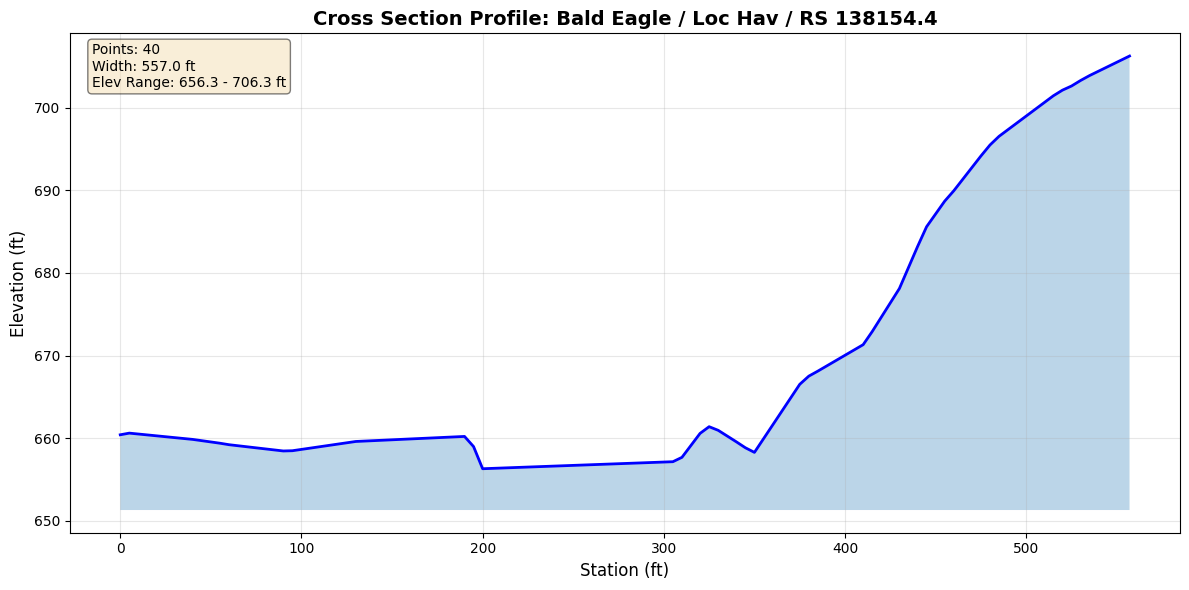

In [8]:
# Plot cross section profile
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sta_elev['Station'], sta_elev['Elevation'], 'b-', linewidth=2, label='Cross Section')
ax.fill_between(sta_elev['Station'], sta_elev['Elevation'],
                 sta_elev['Elevation'].min() - 5,
                 alpha=0.3)

ax.grid(True, alpha=0.3)
ax.set_xlabel('Station (ft)', fontsize=12)
ax.set_ylabel('Elevation (ft)', fontsize=12)
ax.set_title(f'Cross Section Profile: {river} / {reach} / RS {rs}',
             fontsize=14, fontweight='bold')

# Add statistics annotation
stats_text = f'Points: {len(sta_elev)}\n'
stats_text += f'Width: {sta_elev["Station"].max() - sta_elev["Station"].min():.1f} ft\n'
stats_text += f'Elev Range: {sta_elev["Elevation"].min():.1f} - {sta_elev["Elevation"].max():.1f} ft'
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10)

plt.tight_layout()
plt.show()

### 1.5 Modify Cross Section Geometry (Round-Trip Example)

In [9]:
# NOTE: This cell modifies the geometry file!
# Uncomment to actually modify the file (backup is created automatically)

# # Read original data
# original_sta_elev = RasGeometry.get_station_elevation(geom_file, river, reach, rs)
# print(f"Original mean elevation: {original_sta_elev['Elevation'].mean():.3f} ft")

# # Modify elevations (raise by 1 foot)
# modified_sta_elev = original_sta_elev.copy()
# modified_sta_elev['Elevation'] += 1.0

# # Write back to file (creates .bak backup automatically)
# RasGeometry.set_station_elevation(geom_file, river, reach, rs, modified_sta_elev)
# print(f"\n✓ Modified geometry written to file")
# print(f"  Backup created: {geom_file}.bak")

# # Verify round-trip
# readback_sta_elev = RasGeometry.get_station_elevation(geom_file, river, reach, rs)
# print(f"\nReadback mean elevation: {readback_sta_elev['Elevation'].mean():.3f} ft")
# print(f"Difference: {abs(modified_sta_elev['Elevation'].mean() - readback_sta_elev['Elevation'].mean()):.6f} ft")

# # Restore original (using backup)
# import shutil
# shutil.copy2(str(geom_file) + '.bak', geom_file)
# print(f"\n✓ Original geometry restored from backup")

print("Modification example is commented out to protect geometry file.")
print("Uncomment the code above to test round-trip operations.")

Modification example is commented out to protect geometry file.
Uncomment the code above to test round-trip operations.


## Section 2: Hydraulic Property Tables (HTAB)

Property tables contain preprocessed hydraulic properties (area, conveyance, wetted perimeter, etc.) as functions of elevation. These enable hydraulic analysis without re-running HEC-RAS.

**IMPORTANT:** Property tables only exist in preprocessed geometry HDF files. Run `RasCmdr.compute_plan()` to generate them.

### Understanding Hydraulic Property Tables

HEC-RAS pre-computes hydraulic properties at discrete elevations.

**Why HTABs Matter**:
- Used during flow computations
- Interpolation between table values
- Insufficient range causes errors

### Verification
- Check elevation range covers expected WSE
- Verify monotonic increase in area/conveyance

### 2.1 Generate Preprocessed Geometry HDF

### 2.2 Extract HTAB for a Cross Section

In [10]:
# Extract hydraulic property table
river = "Bald Eagle"
reach = "Loc Hav"
rs = "138154.4"

htab = HdfHydraulicTables.get_xs_htab(geom_hdf, river, reach, rs)

print(f"Hydraulic Property Table for {river} / {reach} / RS {rs}")
print(f"\nTable dimensions: {len(htab)} elevations × {len(htab.columns)} properties")
print(f"Elevation range: {htab['Elevation'].min():.2f} to {htab['Elevation'].max():.2f} ft")

print("\nAvailable properties:")
for col in htab.columns:
    print(f"  - {col}")

print("\nFirst 5 rows:")
display.display(htab.head())

2025-12-16 21:49:41 - ras_commander.hdf.HdfHydraulicTables - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.g01.hdf


2025-12-16 21:49:41 - ras_commander.hdf.HdfHydraulicTables - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.g01.hdf


2025-12-16 21:49:41 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 51 elevations × 26 properties


2025-12-16 21:49:41 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted HTAB for Bald Eagle/Loc Hav/RS 138154.4: 51 elevations, 26 properties


Hydraulic Property Table for Bald Eagle / Loc Hav / RS 138154.4

Table dimensions: 51 elevations × 26 properties
Elevation range: 656.30 to 705.80 ft

Available properties:
  - Elevation
  - Area_LOB
  - Area_Chan
  - Area_ROB
  - Area_Ineff_LOB
  - Area_Ineff_Chan
  - Area_Ineff_ROB
  - Conv_LOB
  - Conv_Chan
  - Conv_ROB
  - WP_LOB
  - WP_Chan
  - WP_ROB
  - Mann_N_LOB
  - Mann_N_Chan
  - Mann_N_ROB
  - Top_Width
  - Top_Width_LOB
  - Top_Width_Chan
  - Top_Width_ROB
  - Alpha
  - Storage_Area
  - Beta
  - Area_Total
  - Conveyance_Total
  - Wetted_Perimeter_Total

First 5 rows:


,Elevation,Area_LOB,Area_Chan,Area_ROB,Area_Ineff_LOB,Area_Ineff_Chan,Area_Ineff_ROB,Conv_LOB,Conv_Chan,Conv_ROB,...,Top_Width,Top_Width_LOB,Top_Width_Chan,Top_Width_ROB,Alpha,Storage_Area,Beta,Area_Total,Conveyance_Total,Wetted_Perimeter_Total
0,656.299988,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1.000000,0.000000,0.000000,0.000000
1,656.799988,0.000000,15.674454,0.0,0.000000,15.674454,0.0,0.000000,230.763748,0.0,...,62.697815,0.000000,62.697815,0.0,1.000000,0.0,1.000000,15.674454,230.763748,62.825043
2,657.799988,0.000000,116.927422,0.0,0.000000,116.927422,0.0,0.000000,4426.948730,0.0,...,113.217026,0.000000,113.217026,0.0,1.000000,0.0,1.000000,116.927422,4426.948730,113.641609
3,658.799988,5.692433,234.416946,0.0,5.692433,234.416946,0.0,47.807816,13194.948242,0.0,...,153.563675,28.814926,124.748749,0.0,1.037918,0.0,1.017451,240.109375,13242.755859,154.503967
4,659.799988,69.582207,367.637421,0.0,69.582207,367.637421,0.0,1284.827271,25577.912109,0.0,...,250.028366,108.041672,141.986694,0.0,1.225288,0.0,1.092600,437.219635,26862.740234,251.514709


### 2.3 Generate Rating Curves

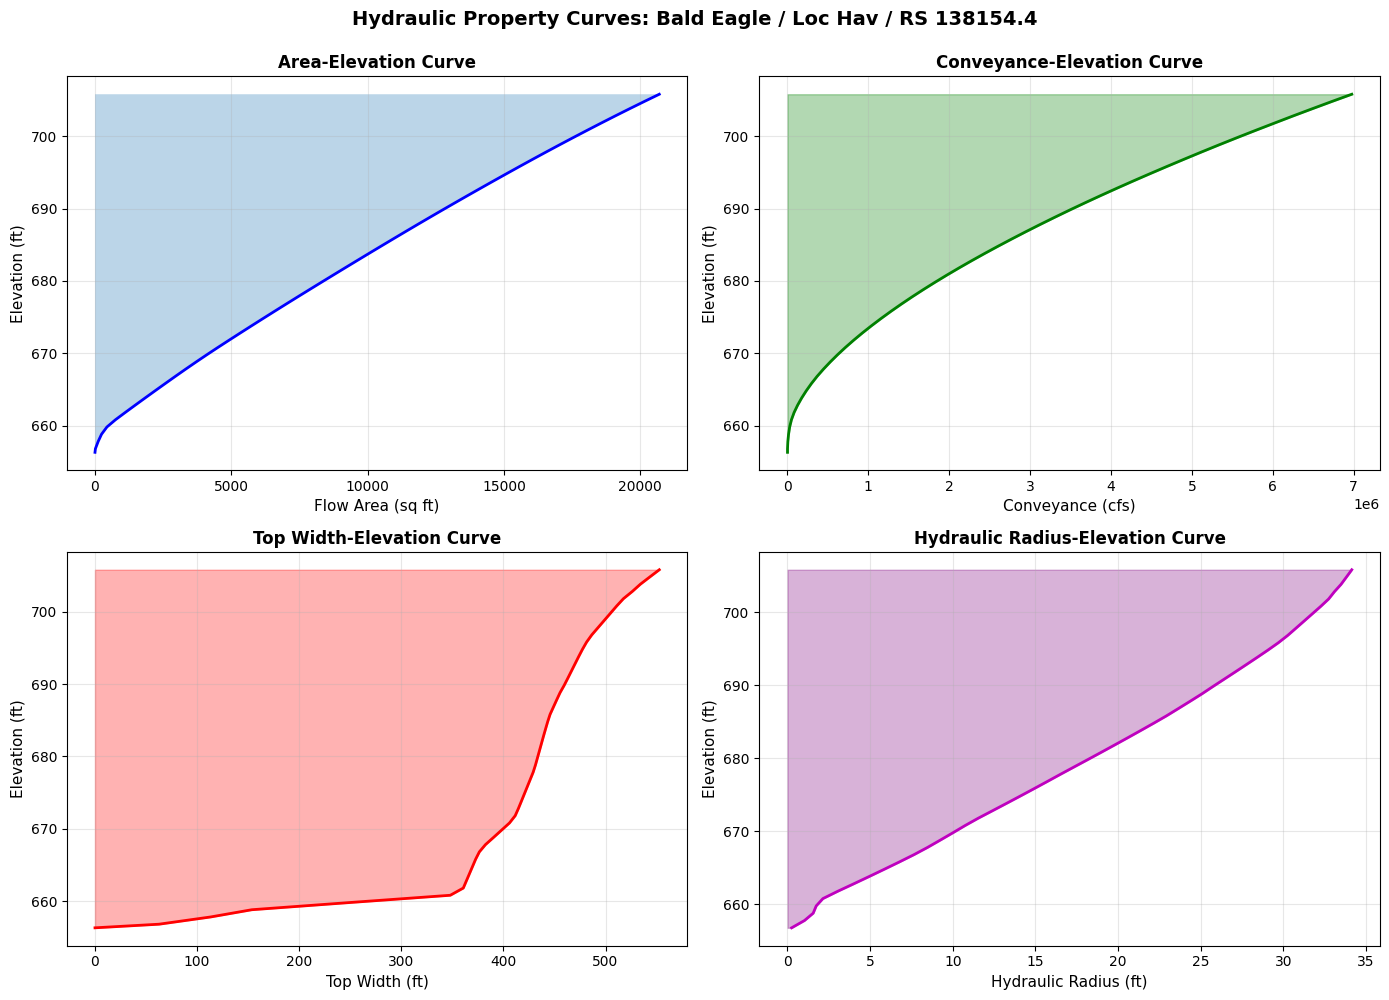


Maximum Hydraulic Properties:
  Max Area: 20701.2 sq ft
  Max Conveyance: 6977025.0 cfs
  Max Hydraulic Radius: 34.14 ft
  Max Top Width: 552.6 ft


In [11]:
# Calculate hydraulic radius
htab['Hydraulic_Radius'] = htab['Area_Total'] / htab['Wetted_Perimeter_Total']
htab['Hydraulic_Radius'] = htab['Hydraulic_Radius'].replace([np.inf, -np.inf], 0)

# Create 4-panel rating curve plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Area vs Elevation
ax1 = axes[0, 0]
ax1.plot(htab['Area_Total'], htab['Elevation'], 'b-', linewidth=2)
ax1.fill_betweenx(htab['Elevation'], 0, htab['Area_Total'], alpha=0.3)
ax1.set_xlabel('Flow Area (sq ft)', fontsize=11)
ax1.set_ylabel('Elevation (ft)', fontsize=11)
ax1.set_title('Area-Elevation Curve', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Conveyance vs Elevation
ax2 = axes[0, 1]
ax2.plot(htab['Conveyance_Total'], htab['Elevation'], 'g-', linewidth=2)
ax2.fill_betweenx(htab['Elevation'], 0, htab['Conveyance_Total'], alpha=0.3, color='green')
ax2.set_xlabel('Conveyance (cfs)', fontsize=11)
ax2.set_ylabel('Elevation (ft)', fontsize=11)
ax2.set_title('Conveyance-Elevation Curve', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Top Width vs Elevation
ax3 = axes[1, 0]
ax3.plot(htab['Top_Width'], htab['Elevation'], 'r-', linewidth=2)
ax3.fill_betweenx(htab['Elevation'], 0, htab['Top_Width'], alpha=0.3, color='red')
ax3.set_xlabel('Top Width (ft)', fontsize=11)
ax3.set_ylabel('Elevation (ft)', fontsize=11)
ax3.set_title('Top Width-Elevation Curve', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Hydraulic Radius vs Elevation
ax4 = axes[1, 1]
ax4.plot(htab['Hydraulic_Radius'], htab['Elevation'], 'm-', linewidth=2)
ax4.fill_betweenx(htab['Elevation'], 0, htab['Hydraulic_Radius'], alpha=0.3, color='purple')
ax4.set_xlabel('Hydraulic Radius (ft)', fontsize=11)
ax4.set_ylabel('Elevation (ft)', fontsize=11)
ax4.set_title('Hydraulic Radius-Elevation Curve', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

fig.suptitle(f'Hydraulic Property Curves: {river} / {reach} / RS {rs}',
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\nMaximum Hydraulic Properties:")
print(f"  Max Area: {htab['Area_Total'].max():.1f} sq ft")
print(f"  Max Conveyance: {htab['Conveyance_Total'].max():.1f} cfs")
print(f"  Max Hydraulic Radius: {htab['Hydraulic_Radius'].max():.2f} ft")
print(f"  Max Top Width: {htab['Top_Width'].max():.1f} ft")

### 2.4 Find Hydraulic Properties at Specific Elevation

In [12]:
# Find properties at specific water surface elevation
target_elev = 665.0

# Find closest elevation in table
idx = (htab['Elevation'] - target_elev).abs().idxmin()
actual_elev = htab.loc[idx, 'Elevation']

print(f"Target elevation: {target_elev:.2f} ft")
print(f"Closest table elevation: {actual_elev:.2f} ft\n")

print(f"Hydraulic properties at elevation {actual_elev:.2f} ft:")
print(f"  Flow Area: {htab.loc[idx, 'Area_Total']:.1f} sq ft")
print(f"  Conveyance: {htab.loc[idx, 'Conveyance_Total']:.1f} cfs")
print(f"  Wetted Perimeter: {htab.loc[idx, 'Wetted_Perimeter_Total']:.1f} ft")
print(f"  Top Width: {htab.loc[idx, 'Top_Width']:.1f} ft")
print(f"  Hydraulic Radius: {htab.loc[idx, 'Hydraulic_Radius']:.2f} ft")
print(f"  Velocity Coefficient (Alpha): {htab.loc[idx, 'Alpha']:.3f}")

Target elevation: 665.00 ft
Closest table elevation: 664.80 ft

Hydraulic properties at elevation 664.80 ft:
  Flow Area: 2202.4 sq ft
  Conveyance: 231547.8 cfs
  Wetted Perimeter: 376.8 ft
  Top Width: 369.8 ft
  Hydraulic Radius: 5.84 ft
  Velocity Coefficient (Alpha): 1.220


### 2.5 Batch Extract HTABs for Multiple Cross Sections

In [13]:
# Extract HTABs for all cross sections
print("Extracting property tables for all cross sections...")
print("(This may take a few seconds)\n")

all_htabs = HdfHydraulicTables.get_all_xs_htabs(geom_hdf)

print(f"Total HTABs extracted: {len(all_htabs)}")

# Calculate statistics across all cross sections
stats_list = []
for (river, reach, rs), htab_df in list(all_htabs.items())[:10]:  # First 10 for demo
    htab_df['Hydraulic_Radius'] = htab_df['Area_Total'] / htab_df['Wetted_Perimeter_Total']
    htab_df['Hydraulic_Radius'] = htab_df['Hydraulic_Radius'].replace([np.inf, -np.inf], 0)

    stats_list.append({
        'RS': rs,
        'Max_Area': htab_df['Area_Total'].max(),
        'Max_Conveyance': htab_df['Conveyance_Total'].max(),
        'Max_Hydraulic_Radius': htab_df['Hydraulic_Radius'].max(),
        'Num_Elevations': len(htab_df)
    })

stats_df = pd.DataFrame(stats_list)

print("\nStatistics for first 10 cross sections:")
display.display(stats_df)

2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.g01.hdf


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_20\BaldEagle.g01.hdf


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 51 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 67 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 68 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 40 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 41 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 23 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 23 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 26 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 27 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 30 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 28 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 80 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 86 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 33 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 43 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 45 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 29 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 26 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 27 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 50 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 40 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 31 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 31 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 33 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 39 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 43 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 40 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 41 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 49 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 49 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 55 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 60 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 62 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 49 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 42 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 59 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 91 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 83 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 63 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 66 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 69 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 64 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 66 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 58 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 57 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 63 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 58 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 72 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 91 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 62 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 62 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 76 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 87 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 97 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 100 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


Extracting property tables for all cross sections...
(This may take a few seconds)



2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 95 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 95 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 73 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 45 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 36 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 26 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 34 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 70 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 68 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 56 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 28 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 23 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 22 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 22 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 45 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 73 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 91 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 69 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 67 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 75 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 72 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 76 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 64 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 65 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 62 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 44 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 45 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 52 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 65 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 59 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 76 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 76 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 66 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 58 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 54 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 56 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 66 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 63 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 66 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 64 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 64 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 59 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 62 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 58 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 56 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 52 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 69 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 92 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 73 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 79 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 61 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 41 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 42 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 25 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 41 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 43 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 77 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 57 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 54 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 43 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 60 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 88 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 80 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 77 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 34 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 33 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 35 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 40 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 45 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 44 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 50 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 39 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 40 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 50 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 46 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 47 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 48 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 45 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 55 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 62 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 65 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 98 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 99 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 101 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 95 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 84 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 81 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 71 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 51 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 63 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 96 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 102 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 53 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 54 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 60 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 51 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 51 elevations × 26 properties


2025-12-16 21:49:42 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted 178 property tables from BaldEagle.g01.hdf


Total HTABs extracted: 178

Statistics for first 10 cross sections:


,RS,Max_Area,Max_Conveyance,Max_Hydraulic_Radius,Num_Elevations
0,138154.4,20701.232422,6977025.00,34.144203,51
1,137690.8,44466.535156,16715759.00,48.128937,67
2,137327.0,45780.699219,17608260.00,50.108379,68
3,136564.9,21783.722656,5806229.50,26.523174,40
4,136202.3,26415.556641,7483566.50,29.737156,41
5,135591.4,14490.575195,2507643.00,15.844055,23
6,135068.7,20730.187500,3290782.25,16.082315,23
7,134487.2,22591.662109,4204560.50,19.019423,26
8,133881.0,23631.132812,4800342.50,20.430098,27
9,133446.1,23645.011719,4819964.00,19.912445,30


## Section 3: Lateral Structure Operations

Lateral structures are overflow weirs or connections along a river reach. We'll demonstrate extracting and visualizing these structures.

### Understanding Lateral Structures

Lateral structures represent flow entering/leaving channel.

**Key Parameters**:
- Station location
- Weir coefficient
- Crest elevation

### Verification
- Count matches HEC-RAS GUI
- Stations within cross section limits

# Load Geometry XX in project XX

In [19]:
muncie_path = RasExamples.extract_project(PROJECT_NAME, suffix="201")
print(muncie_path)

init_ras_project(muncie_path)

2025-12-16 21:49:44 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-16 21:49:44 - ras_commander.RasExamples - INFO - Extracting project 'Muncie' as 'Muncie_20'


2025-12-16 21:49:44 - ras_commander.RasExamples - INFO - Successfully extracted project 'Muncie' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_20


2025-12-16 21:49:44 - ras_commander.RasPrj - INFO - No HEC-RAS Version Specified.Attempting to detect HEC-RAS version from plan files.


2025-12-16 21:49:44 - ras_commander.RasPrj - INFO - Searching for plan files in C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_20


2025-12-16 21:49:44 - ras_commander.RasPrj - INFO - Found plan file: Muncie.p01


2025-12-16 21:49:44 - ras_commander.RasPrj - INFO - Successfully read plan file with utf-8 encoding


2025-12-16 21:49:44 - ras_commander.RasPrj - INFO - Found Program Version=5.00 in Muncie.p01


2025-12-16 21:49:44 - ras_commander.RasPrj - INFO - Checking RAS executable path: C:\Program Files (x86)\HEC\HEC-RAS\5.0\Ras.exe


2025-12-16 21:49:44 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_20\Muncie.rasmap


C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_20


In [20]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,1,NaN,NaN,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,1,Pardiso (Direct),2D Interior Area,None,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,1,Pardiso (Direct),2D Interior Area,None,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady


In [21]:
ras.geom_df

,geom_file,geom_number,full_path,hdf_path
0,g01,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,g02,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
2,g04,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [22]:
geom_number = "01"
geom_row = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number].iloc[0]

geom_file = Path(geom_row["full_path"])
geom_hdf = Path(geom_row["hdf_path"])

### 3.1 List Lateral Structures

In [23]:
# Path to geometry with lateral structures
lateral_geom_file = geom_file

print(f"Geometry file: {lateral_geom_file}")

Geometry file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_20\Muncie.g01


In [24]:


# Extract lateral structures
lat_strucs = GeomLateral.get_lateral_structures(lateral_geom_file)

print(f"\nLateral structures found: {len(lat_strucs)}")

if len(lat_strucs) > 0:
    print("\nLateral structure inventory:")
    display.display(lat_strucs[['River', 'Reach', 'RS', 'Position', 'Width', 'Coefficient', 'Distance', 'Description']])
else:
    print("No lateral structures found in this geometry file")

2025-12-16 21:49:44 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in Muncie.g01



Lateral structures found: 0
No lateral structures found in this geometry file


### 3.2 Extract and Visualize Lateral Weir Profile

In [25]:
if len(lat_strucs) > 0:
    # Get profile for first lateral structure
    first_lat = lat_strucs.iloc[0]
    river = first_lat['River']
    reach = first_lat['Reach']
    rs = first_lat['RS']
    position = first_lat['Position']

    print(f"Extracting lateral weir profile:")
    print(f"  Location: {river} / {reach} / RS {rs}")
    print(f"  Position: {position}")
    print(f"  Description: {first_lat['Description']}")

    profile = GeomLateral.get_weir_profile(lateral_geom_file, river, reach, rs, position)

    print(f"\nWeir Profile:")
    print(f"  Points: {len(profile)}")
    print(f"  Station range: {profile['Station'].min():.1f} to {profile['Station'].max():.1f} ft")
    print(f"  Elevation range: {profile['Elevation'].min():.2f} to {profile['Elevation'].max():.2f} ft")

    # Plot weir profile
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(profile['Station'], profile['Elevation'], 'go-', linewidth=2, markersize=6)
    ax.fill_between(profile['Station'], profile['Elevation'],
                     profile['Elevation'].min() - 2, alpha=0.3, color='green')
    ax.set_xlabel('Station (ft)', fontsize=11)
    ax.set_ylabel('Weir Crest Elevation (ft)', fontsize=11)
    ax.set_title(f'Lateral Weir Crest Profile: RS {rs}, Position {position}',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping lateral weir visualization - no laterals found")

Skipping lateral weir visualization - no laterals found


## Section 4: Batch Processing Example

Demonstrate how to automate operations across multiple geometry elements for batch analysis.

### 4.1 Calculate Statistics for All Cross Sections

In [31]:
# Get all cross sections
xs_df = RasGeometry.get_cross_sections(geom_file)

print(f"Processing {len(xs_df)} cross sections...")

# Calculate geometry statistics for first 10 XS (for speed)
xs_stats = []
for idx, xs in xs_df.head(10).iterrows():
    try:
        sta_elev = RasGeometry.get_station_elevation(geom_file, xs['River'], xs['Reach'], xs['RS'])

        stats = {
            'RS': xs['RS'],
            'Points': len(sta_elev),
            'Min_Elev': sta_elev['Elevation'].min(),
            'Max_Elev': sta_elev['Elevation'].max(),
            'Relief': sta_elev['Elevation'].max() - sta_elev['Elevation'].min(),
            'Width': sta_elev['Station'].max() - sta_elev['Station'].min(),
            'Channel_Length': xs['Length_Channel']
        }
        xs_stats.append(stats)

    except Exception as e:
        print(f"  Warning: Could not process RS {xs['RS']}: {e}")

xs_stats_df = pd.DataFrame(xs_stats)

print()
print("Statistics for first 10 cross sections:")
display.display(xs_stats_df)

2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 63 cross sections from Muncie.g01


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 134 station/elevation pairs for White/Muncie/RS 15696.24


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 93 station/elevation pairs for White/Muncie/RS 15485.51


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 88 station/elevation pairs for White/Muncie/RS 15370.43


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 63 station/elevation pairs for White/Muncie/RS 15205.29


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 43 station/elevation pairs for White/Muncie/RS 15013.20


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 39 station/elevation pairs for White/Muncie/RS 14917.36


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 39 station/elevation pairs for White/Muncie/RS 14856.24


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 40 station/elevation pairs for White/Muncie/RS 14787.40


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 40 station/elevation pairs for White/Muncie/RS 14697.22


2025-12-16 21:49:44 - ras_commander.geom.GeomCrossSection - INFO - Extracted 42 station/elevation pairs for White/Muncie/RS 14535.60


Processing 63 cross sections...

Statistics for first 10 cross sections:


,RS,Points,Min_Elev,Max_Elev,Relief,Width,Channel_Length
0,15696.24,134,936.99,963.04,26.05,807.07,210.73
1,15485.51,93,937.78,959.76,21.98,780.63,115.09
2,15370.43,88,937.78,959.97,22.19,645.10,165.14
3,15205.29,63,941.39,948.81,7.42,476.82,192.09
4,15013.20,43,940.73,946.97,6.24,381.34,95.84
5,14917.36,39,941.06,947.62,6.56,274.72,61.12
6,14856.24,39,940.18,947.62,7.44,259.72,68.84
7,14787.40,40,937.78,947.95,10.17,251.89,90.18
8,14697.22,40,938.88,947.95,9.07,263.44,161.62
9,14535.60,42,938.77,949.61,10.84,276.76,91.89


### 4.2 Visualize Cross Section Statistics Along Reach

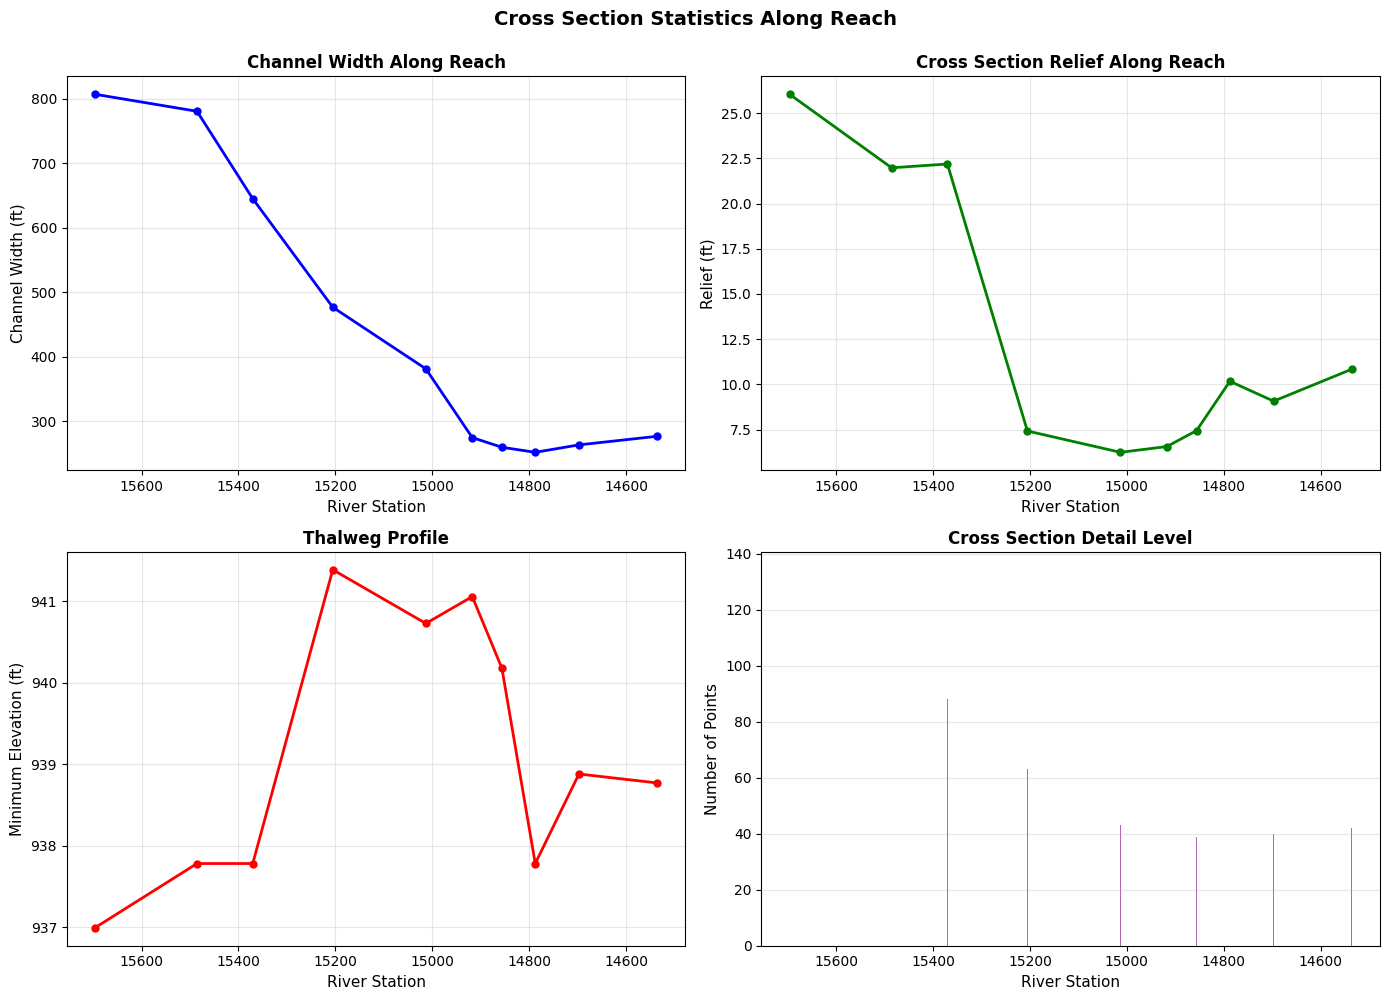

In [32]:
# Plot cross section properties along the reach
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convert RS to numeric for plotting
xs_stats_df['RS_num'] = pd.to_numeric(xs_stats_df['RS'], errors='coerce')

# Plot 1: Channel width along reach
ax1 = axes[0, 0]
ax1.plot(xs_stats_df['RS_num'], xs_stats_df['Width'], 'b-o', linewidth=2, markersize=5)
ax1.set_xlabel('River Station', fontsize=11)
ax1.set_ylabel('Channel Width (ft)', fontsize=11)
ax1.set_title('Channel Width Along Reach', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()  # Invert so upstream is on left

# Plot 2: Relief (elevation change across XS)
ax2 = axes[0, 1]
ax2.plot(xs_stats_df['RS_num'], xs_stats_df['Relief'], 'g-o', linewidth=2, markersize=5)
ax2.set_xlabel('River Station', fontsize=11)
ax2.set_ylabel('Relief (ft)', fontsize=11)
ax2.set_title('Cross Section Relief Along Reach', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

# Plot 3: Minimum elevation (thalweg)
ax3 = axes[1, 0]
ax3.plot(xs_stats_df['RS_num'], xs_stats_df['Min_Elev'], 'r-o', linewidth=2, markersize=5)
ax3.set_xlabel('River Station', fontsize=11)
ax3.set_ylabel('Minimum Elevation (ft)', fontsize=11)
ax3.set_title('Thalweg Profile', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.invert_xaxis()

# Plot 4: Number of points per XS
ax4 = axes[1, 1]
ax4.bar(xs_stats_df['RS_num'], xs_stats_df['Points'], color='purple', alpha=0.6)
ax4.set_xlabel('River Station', fontsize=11)
ax4.set_ylabel('Number of Points', fontsize=11)
ax4.set_title('Cross Section Detail Level', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.invert_xaxis()

fig.suptitle('Cross Section Statistics Along Reach', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Section 5: Practical Application - Sensitivity Study

Real-world use case: Setting up geometry modifications for parameter sensitivity analysis.

In [34]:
# Example: Prepare geometry for Manning's n sensitivity study
# (Conceptual - actual Manning's n methods not yet implemented)

print("Sensitivity Study Example:")
print("\nPreparing geometry for parameter sensitivity analysis...")

# Get cross sections for modification
xs_subset = xs_df.head(5)

print(f"\nSelected {len(xs_subset)} cross sections for study:")
for idx, xs in xs_subset.iterrows():
    print(f"  - RS {xs['RS']}")

print("\nFor each cross section, you could:")
print("  1. Extract current geometry with get_station_elevation()")
print("  2. Extract current Manning's n (future: get_mannings_n())")
print("  3. Modify Manning's n values (e.g., ±10%, ±20%)")
print("  4. Write modified values (future: set_mannings_n())")
print("  5. Run RasCmdr.compute_plan() for each scenario")
print("  6. Compare results to assess sensitivity")

print("\nThis workflow enables automated sensitivity studies!")

Sensitivity Study Example:

Preparing geometry for parameter sensitivity analysis...

Selected 5 cross sections for study:
  - RS 15696.24
  - RS 15485.51
  - RS 15370.43
  - RS 15205.29
  - RS 15013.20

For each cross section, you could:
  1. Extract current geometry with get_station_elevation()
  2. Extract current Manning's n (future: get_mannings_n())
  3. Modify Manning's n values (e.g., ±10%, ±20%)
  4. Write modified values (future: set_mannings_n())
  5. Run RasCmdr.compute_plan() for each scenario
  6. Compare results to assess sensitivity

This workflow enables automated sensitivity studies!


## Summary

### Methods Demonstrated

**Cross Section Operations (RasGeometry)**:
- `get_cross_sections()` - List all cross sections with metadata
- `get_station_elevation()` - Extract station/elevation pairs
- `set_station_elevation()` - Modify geometry with automatic backup

**Hydraulic Property Tables (HdfHydraulicTables)**:
- `get_htab()` - Extract preprocessed hydraulic properties
- Rating curve generation from property tables

**Lateral Structures (GeomLateral)**:
- `get_lateral_structures()` - List lateral structures
- `get_lateral_structure_profile()` - Extract weir profiles

### Key Capabilities

1. **Geometry Modification**: Round-trip read/modify/write with automatic backups
2. **Hydraulic Analysis**: Extract rating curves and property tables
3. **Batch Processing**: Analyze statistics across all cross sections
4. **Visualization**: Profile plots, rating curves, reach statistics

### See Also

- `202_2d_plaintext_geometry.ipynb` - 2D geometry operations (storage areas, SA/2D connections)
- `400_1d_hdf_data_extraction.ipynb` - 1D HDF results extraction
